Code for **"Blind restoration of a JPEG-compressed image"** and **"Blind image denoising"** figures. Select `fname` below to switch between the two.

- To see overfitting set `num_iter` to a large value.

# Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.optim
import torch.nn as nn
from torch.autograd import Variable

import utils
from model import create_model

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor

sigma = 25
sigma_ = sigma/255.

In [2]:
fname = 'data/denoising/aalto_logo_2.png'

# Load image

## Motivation behind the selection of the image
In denoising we want to test if NN can help us to learn useful features about the underlying image. If that happens we can stop the learning early enough to make sure that the network won't learn any unwanted features from the corrupted image. In this case image is corrupted with generated noise. Image is also blurry. Our goal is to see if generated noise can be removed with early stopping and also we want to see if we can make the image sharper.

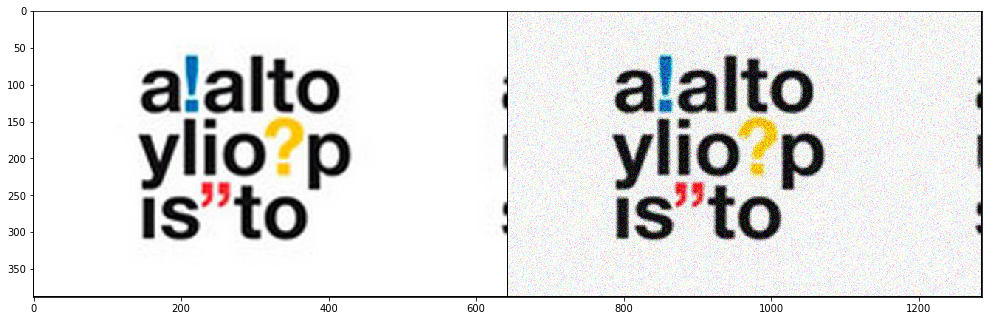

In [3]:
image = utils.get_image(fname)
img_pil = utils.crop_image(image, d=32)
img_np = utils.pil_to_np(img_pil)

_, img_noisy_np = utils.get_noisy_image(img_np, sigma_)

utils.plot_image_grid([img_np, img_noisy_np], 10, 15);

# Setup

In [4]:
INPUT = 'noise'
pad = 'zero'

reg_noise_std = 1./30.
LR = 0.01
OPTIMIZER='adam'

input_depth = 64

net = create_model(downsample_channels = [8, 16, 32, 64, 128],
                    upsample_channels = [8, 16, 32, 64, 128],
                    skip_channels = [0, 0, 0, 4, 4],
                    input_channel_size = input_depth,
                    output_channel_size = 3,
                    upsample_mode='bilinear',
                    activation_function=nn.LeakyReLU(0.2, inplace=True),
                    padding_type=pad
                   ).type(dtype)

net = net.type(dtype)

net_input = utils.get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

# Number of parameters in the model
s = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

layer 0
layer 1
layer 2
layer 3
layer 4
Number of params: 577219


In [5]:
num_iter = 6000
show_every = 500
figsize = 10

# Optimize

Starting optimization with ADAM


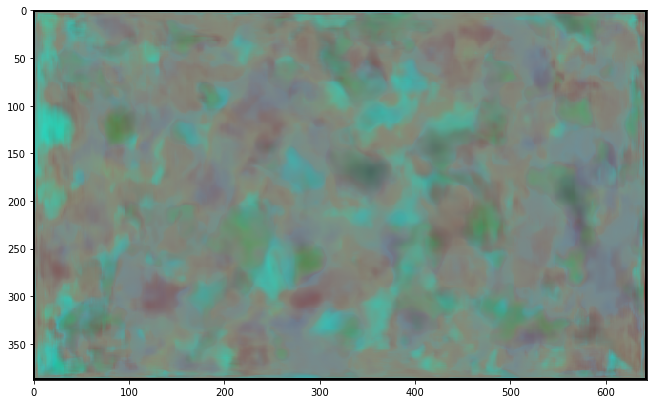

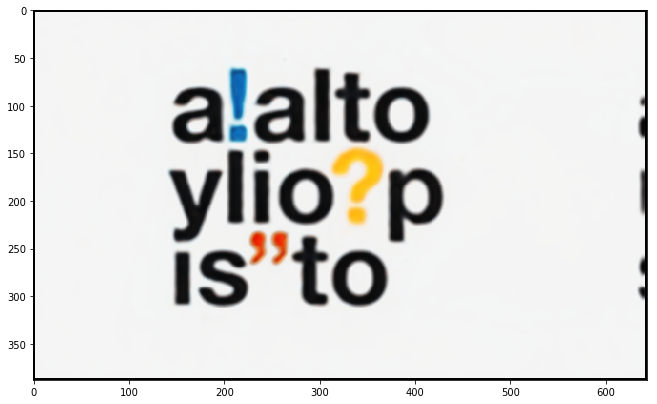

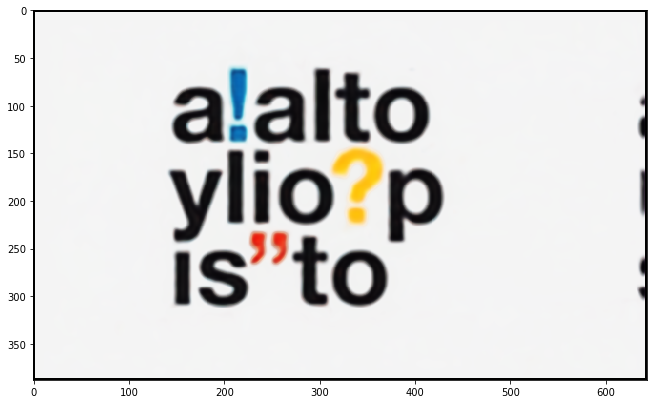

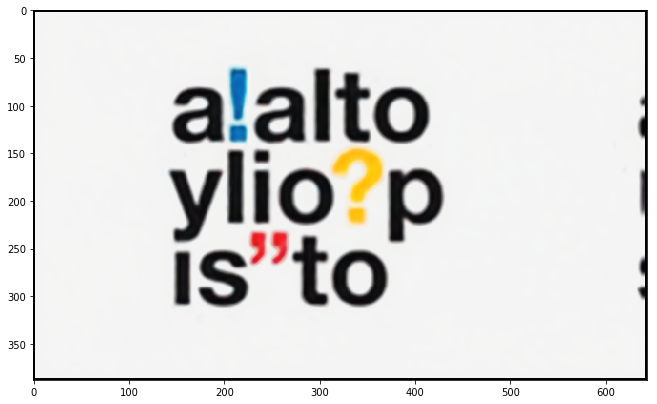

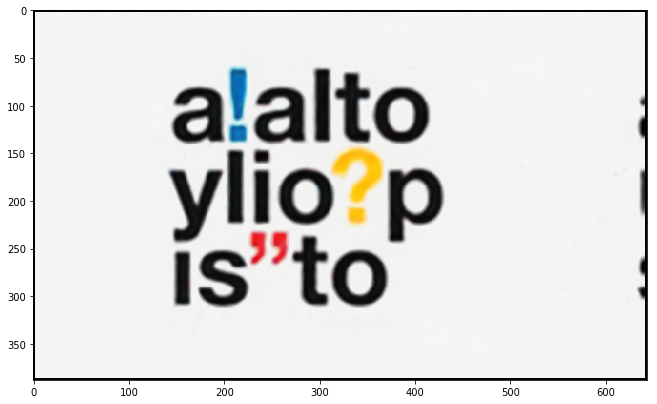

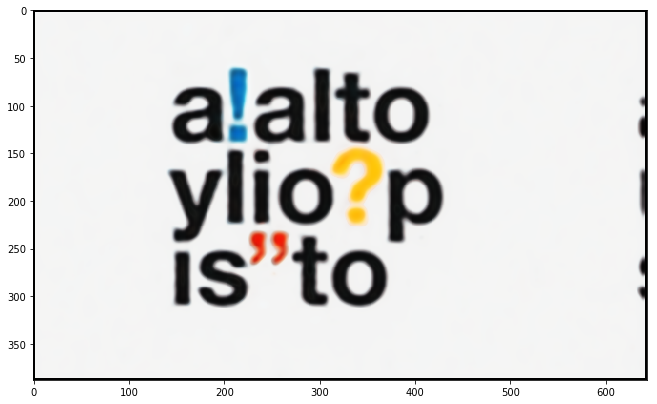

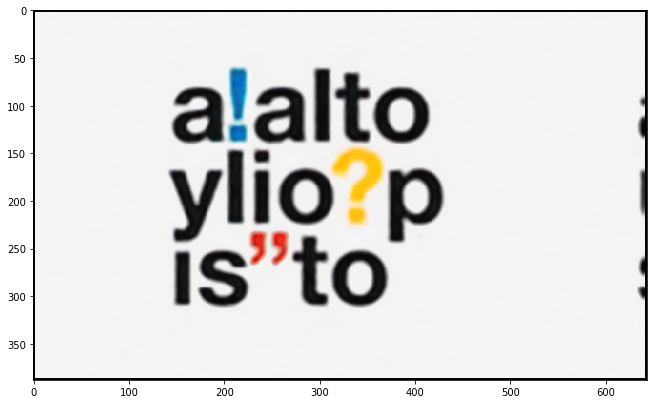

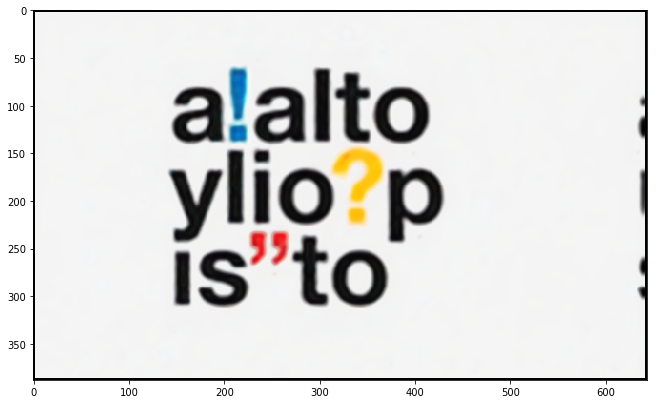

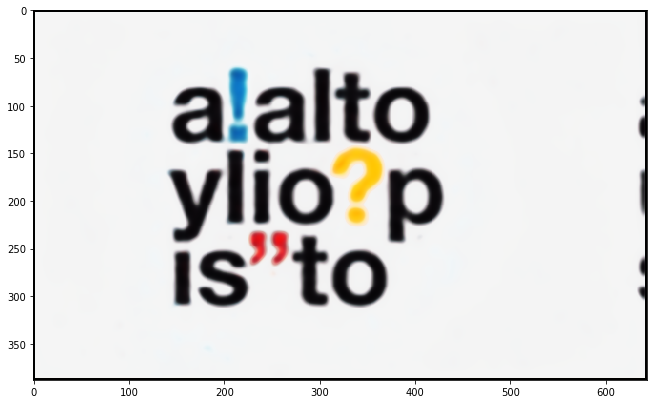

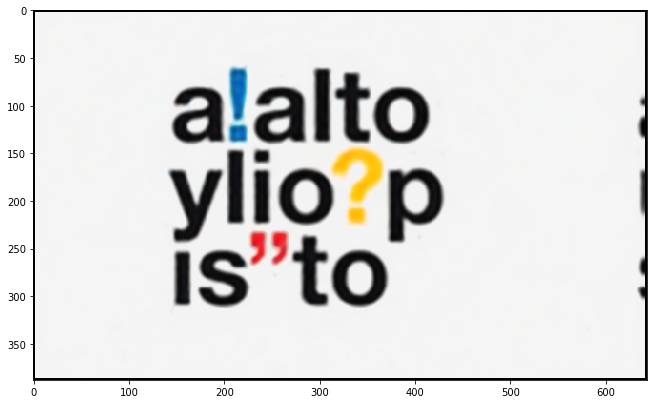

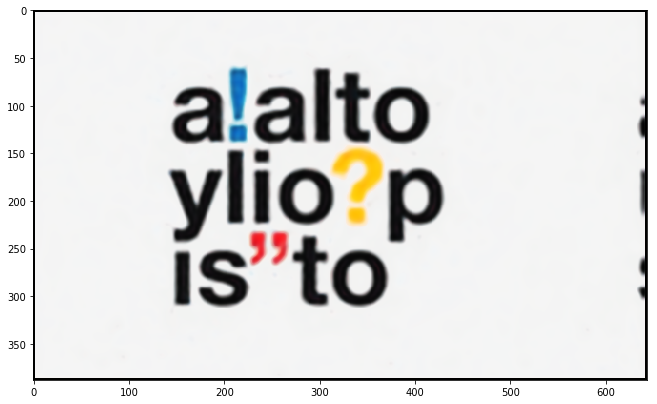

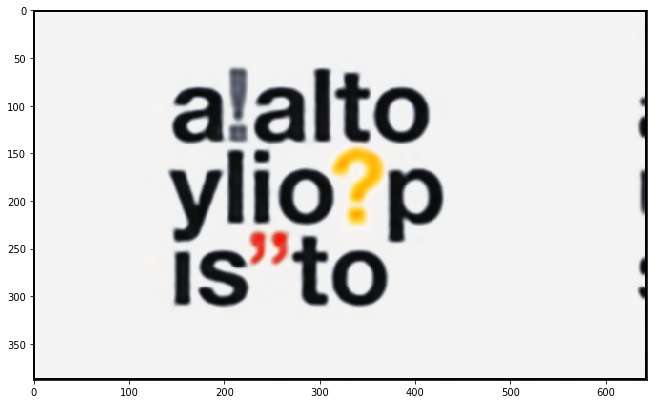

In [6]:
net_input_saved = net_input.data.clone()
noise = net_input.data.clone()

img_noisy_var = utils.np_to_var(img_noisy_np).type(dtype)

# Loss
mse = torch.nn.MSELoss().type(dtype)

i = 0
def closure():
    global i
    
    out = net(net_input)
    total_loss = mse(out, img_noisy_var)
    total_loss.backward()
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.data[0]), '\r', end='')
    if  i % show_every == 0:
        out_np = utils.var_to_np(out)
        utils.plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss

print('Starting optimization with ADAM')
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
        
for j in range(num_iter):
    optimizer.zero_grad()
    closure()
    optimizer.step()

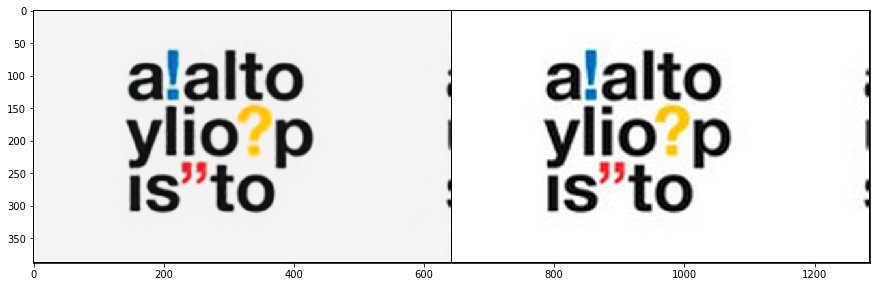

In [7]:
out_np = utils.var_to_np(net(net_input))
q = utils.plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);